<a href="https://colab.research.google.com/github/igrosny/csca5632/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project


# Step 1: Gather data

The data I'm using was aquired by to company I work for, and its a list of job posting that have the word solar on the title or the description

In [1]:
import pandas as pd

# Read the parquet file into a pandas DataFrame
df = pd.read_parquet('solar.parquet')

# Display the first few rows of the DataFrame to verify
print(df.head())

  created_at_date                            doc_title  \
0      2022-06-07               Solar Sales Consultant   
1      2022-11-08              Solar Energy Consultant   
2      2023-04-09                    Solar CAD Drafter   
3      2023-04-05        Branch Administrative Manager   
4      2022-03-24  Administrative Training Coordinator   

                 doc_company  \
0                  MittGroup   
1           Solgen Power LLC   
2         TriSMART Solar LLC   
3              ADT Solar LLC   
4  Abrams Technical Services   

                                     doc_description         doc_location  \
0  Senior Solar Consultant \nSenior Solar Consult...  Las Vegas, NV 89101   
1  \n\n\n \nJoin the 12th fastest growing private...       Louisville, KY   
2  <div>\n <p>TriSMART Solar is full-service prov...    Houston, TX 77073   
3  At ADT Solar, we are passionate about solar en...  Charlotte, NC 28201   
4  \n \n\n  \n\n   \n\n    \n\n     \nJob Details...           Searcy, AR

In [ ]:
df.shape

# Step 2: Identify an Unsupervised Learning Problem

This project leverages unsupervised machine learning models to analyze unstructured text data from job posting descriptions. The primary objectives are twofold: 1) To perform topic modeling (e.g., using LDA or NMF) to identify latent themes, required skills, or job categories present across the postings without prior labeling. 2) To generate dense vector representations (embeddings) for each job description. These embeddings will capture the semantic meaning of the text, allowing for the computation of similarity scores between pairs of job postings to find roles that are similar in content and requirements.

# Step 3: Exploratory Data Analysis

Descriptive Statistics for Description Length:
count    106465.000000
mean       3535.309520
std        1941.525786
min         130.000000
25%        2214.000000
50%        3093.000000
75%        4176.000000
max       40979.000000
Name: description_length, dtype: float64

Descriptive Statistics for Description Word Count:
count    106465.000000
mean        487.162194
std         255.080156
min          20.000000
25%         307.000000
50%         438.000000
75%         576.000000
max        4175.000000
Name: description_word_count, dtype: float64


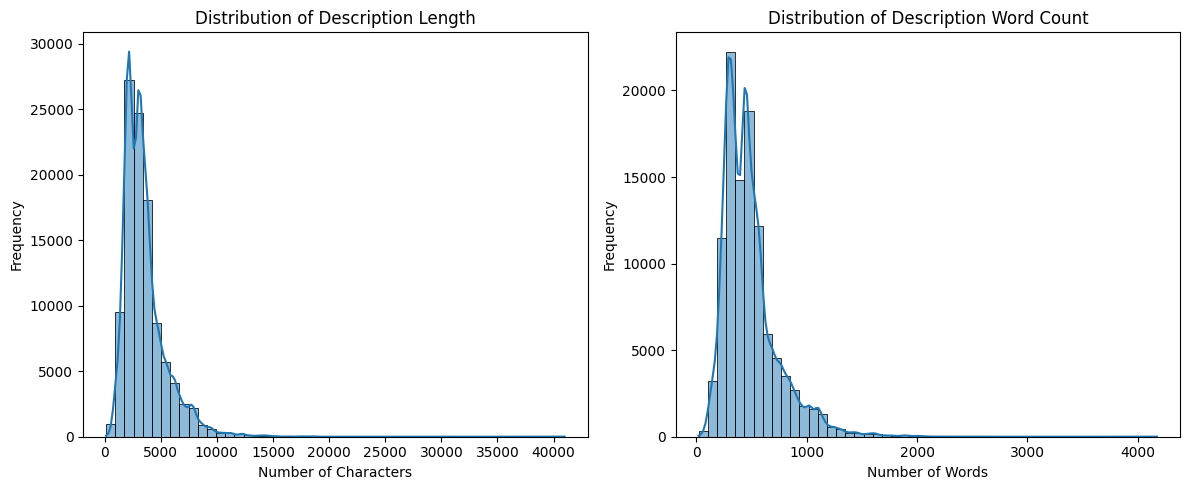


Shortest descriptions:
                                         doc_description  description_length
12485  Representante de ventas solar power.\nTipo de ...                 130
13516  Representante de ventas solar power.\nTipo de ...                 130
43536  Representante de ventas solar power.\nTipo de ...                 130
41670  \n \nRepresentante de ventas solar power.\n\n ...                 154
43401  \n \nRepresentante de ventas solar power.\n\n ...                 154

Longest descriptions:
                                         doc_description  description_length
21819  \n \n\n  \n\n   \n\n    \n\n     \n\n      \n\...               40979
26201  \n \n\n  \n\n   \n\n    \n\n     \n\n      \n\...               40979
56535  \n \n\n  \n\n   \n\n    \n\n     \n\n      \n\...               40979
59519  \n \n\n  \n\n   \n\n    \n\n     \n\n      \n\...               40684
95806  \n \n\n  \n\n   \n\n    \n\n     \n\n      \n\...               40684

Number of potentially empty 

In [34]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the length of each description
df['description_length'] = df['doc_description'].str.len()

# Calculate the number of words in each description
# We split by whitespace to count words
df['description_word_count'] = df['doc_description'].str.split().str.len()

# Display basic statistics for the new columns
print("Descriptive Statistics for Description Length:")
print(df['description_length'].describe())
print("\nDescriptive Statistics for Description Word Count:")
print(df['description_word_count'].describe())

# Plot histograms for the distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['description_length'], bins=50, kde=True)
plt.title('Distribution of Description Length')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['description_word_count'], bins=50, kde=True)
plt.title('Distribution of Description Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Check for potential outliers or unusually short/long descriptions
print("\nShortest descriptions:")
print(df.loc[df['description_length'].nsmallest(5).index][['doc_description', 'description_length']])

print("\nLongest descriptions:")
print(df.loc[df['description_length'].nlargest(5).index][['doc_description', 'description_length']])

# Check for missing or empty descriptions again (though initial info showed none)
print(f"\nNumber of potentially empty descriptions (length <= 1): {df[df['description_length'] <= 1].shape[0]}")


# Clean Data
## Remove non-english posting

In [35]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=9b707439b3425ec325af3a55d6bf755322aa5bf9937880870834b2d2e3591432
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
from langdetect import detect, LangDetectException
from tqdm.auto import tqdm # Optional: for progress bar

def detect_language(text):

    try:
        # Use a minimum length heuristic for more reliable detection
        if isinstance(text, str) and len(text.strip()) > 50:
             return detect(text)
        else:
            # Treat short, non-string, or empty descriptions as 'unknown'
            return 'unknown'
    except LangDetectException:
        # Handle cases where language detection fails (e.g., mixed languages, symbols)
        return 'error'

tqdm.pandas(desc="Detecting language")

print("Detecting language for each job description...")
df['language'] = df['doc_description'].progress_apply(detect_language)

print("\nDetected language distribution:")
print(df['language'].value_counts())

initial_rows = df.shape[0]
print(f"\nOriginal number of rows: {initial_rows}")

df = df[df['language'] == 'en']

df.drop(columns=['language'], inplace=True)

df.reset_index(drop=True, inplace=True)

final_rows = df.shape[0]
print(f"Number of rows after filtering for English: {final_rows}")
print(f"Number of non-English or undetermined rows removed: {initial_rows - final_rows}")

print("\nUpdated DataFrame shape:", df.shape)
print("\nFirst 5 rows of the updated DataFrame:")
print(df.head())

## Remove NA

In [ ]:

df = df.dropna(subset=['doc_description'])
df = df[df['doc_description'] != '']
df = df[df['doc_description'].str.strip() != ""]


# Step 4: perform analysis

This code automatically organizes your job descriptions by first using the efficient SentenceTransformer model (all-MiniLM-L6-v2) to convert each description's text into a numerical vector (embedding) that represents its semantic meaning. Because similar descriptions produce mathematically close embeddings, the KMeans algorithm is then used to partition these embeddings—and thus the original job postings—into 50 distinct clusters based on their proximity. The end result is a categorization of your job postings into meaningful groups according to their content similarity, achieved without manual sorting.

In [8]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import warnings


warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.cluster._kmeans')

NUM_CLUSTERS = 50
MODEL_NAME = 'all-MiniLM-L6-v2'
job_postings = df['doc_description'].tolist()

print(f"Loading pre-trained sentence transformer model: {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)
print(f"Generating embeddings for {len(job_postings)} job postings...")
embeddings = model.encode(job_postings, show_progress_bar=True)

print(f"Embeddings generated. Shape: {embeddings.shape}")

print(f"\nClustering embeddings into {NUM_CLUSTERS} groups using K-Means...")


kmeans = KMeans(n_clusters=NUM_CLUSTERS,
                random_state=42, # for reproducibility
                n_init='auto')

kmeans.fit(embeddings)

cluster_labels = kmeans.labels_

clustered_postings = {i: [] for i in range(NUM_CLUSTERS)}

# Populate the dictionary
for i, label in enumerate(cluster_labels):
    # Store the original index and the text snippet
    clustered_postings[label].append((i, job_postings[i]))



Loading pre-trained sentence transformer model: all-MiniLM-L6-v2...
Generating embeddings for 106465 job postings...


Batches:   0%|          | 0/3328 [00:00<?, ?it/s]

Embeddings generated. Shape: (106465, 384)

Clustering embeddings into 50 groups using K-Means...

--- Job Postings Grouped by Cluster ---


In [13]:
# Print the postings for each cluster
for label, postings in clustered_postings.items():
    print(f"\nCluster {label}: Contains {len(postings)} postings")
    print("-" * (10 + len(str(label))))
    # Limit the number of postings printed per cluster for readability
    limit = 10
    postings_to_show = postings[:limit]

    for idx, text in postings_to_show:
         print(f"  - Posting {idx+1}: {df['doc_title'][idx]}...")

    if len(postings) > limit:
        print(f"  ... (and {len(postings) - limit} more postings in this cluster)")

    # Print the top 20 words of each cluster
    print("\nTop 20 words in this cluster:")
    # Combine all text within a cluster
    all_text_in_cluster = " ".join([text for _, text in postings])

    # Tokenize and count word frequencies
    words = all_text_in_cluster.lower().split()
    word_counts = Counter(words)

    # Remove punctuation and common words (stop words) - improve this list as needed
    stop_words = ['their','job','your','have','be','join', 'each', 'equal','any','will','we','you','work','are', 'our','or','the', 'a', 'an', 'in', 'of', 'to', 'and', 'is', 'for', 'with', 'on', 'that', 'by', 'at', 'this', 'as', '.', ',', ':', ';', '(', ')', '-', '!', '?']
    filtered_words = [(word, count) for word, count in word_counts.items() if word not in stop_words and word.isalpha()]

    # Sort by frequency and take top 20
    top_20_words = sorted(filtered_words, key=lambda item: item[1], reverse=True)[:20]

    for word, count in top_20_words:
          print(f"  - {word}: {count}")

print("\n--- Script Finished ---")


Cluster 0: Contains 3356 postings
-----------
  - Posting 47: Human Resources/Office Administrator...
  - Posting 48: SOLAR CONTRACTS ADMINISTRATOR...
  - Posting 105: Solar Operations Center Manager - Renewable O&M...
  - Posting 133: Logistics Coordinator...
  - Posting 172: Warehouse Assistant...
  - Posting 205: UX/UI Designer...
  - Posting 251: International Logistics Coordinator...
  - Posting 264: Accounts Payable Clerk...
  - Posting 268: Solar Field Tech Leader...
  - Posting 272: Director of O&M - Solar...
  ... (and 3346 more postings in this cluster)

Top 20 words in this cluster:
  - solar: 12793
  - experience: 9283
  - energy: 7736
  - all: 7735
  - ability: 7133
  - customer: 6053
  - other: 5786
  - team: 5242
  - company: 4959
  - skills: 4896
  - service: 4427
  - management: 4140
  - support: 4129
  - insurance: 4056
  - ensure: 4052
  - business: 3933
  - including: 3771
  - strong: 3621
  - years: 3523
  - time: 3327

Cluster 1: Contains 4258 postings
----------

## Using NMF

This code aims to automatically identify the main underlying themes or topics within your collection of job descriptions. It starts by cleaning the text data (making it lowercase, removing punctuation, standardizing spaces) to ensure consistency. Then, it employs TfidfVectorizer to convert the cleaned text into a numerical matrix, weighting words based on their frequency within a document relative to their frequency across all documents, effectively highlighting characteristic terms while filtering common English stop words and very frequent/infrequent terms. Finally, Non-negative Matrix Factorization (NMF), a topic modeling algorithm, is applied to this TF-IDF matrix to decompose it and discover 25 latent topics, with the results displayed by showing the top 10 most important words associated with each identified topic, allowing you to interpret the key subjects discussed in the job postings.

In [14]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import re
import time

NUM_TOPICS = 25
NUM_TOP_WORDS = 10


job_postings = df['doc_description'].tolist()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_postings = [clean_text(post) for post in job_postings]

print("Vectorizing text data using TF-IDF...")

vectorizer = TfidfVectorizer(max_df=0.95,
                             min_df=2,
                             stop_words='english',
                             ngram_range=(1,1))

dtm_tfidf = vectorizer.fit_transform(cleaned_postings)
feature_names = vectorizer.get_feature_names_out()

print(f"Applying NMF to find {NUM_TOPICS} topics...")


nmf_model = NMF(n_components=NUM_TOPICS,
                random_state=42,
                init='nndsvda',
                max_iter=500,
                l1_ratio=0.0,
                solver='cd')


W = nmf_model.fit_transform(dtm_tfidf)
H = nmf_model.components_

def display_topics(model_components, feature_names, num_top_words):
    """Prints the top words for each topic."""
    print("\n--- Top Words per Topic (NMF) ---")
    for topic_idx, topic in enumerate(model_components): # Iterate through rows of H matrix
        # Get the indices of the top words for this topic based on their weights
        top_features_indices = topic.argsort()[:-num_top_words - 1:-1]
        # Get the actual words from the indices
        top_features = [feature_names[i] for i in top_features_indices]
        print(f"Topic {topic_idx}:")
        print(", ".join(top_features))
        print("-" * 30)

display_topics(H, feature_names, NUM_TOP_WORDS)





Streaming output truncated to the last 5000 lines.
Document 105140 (starts with: '<div>
 <p><b>ABOUT US</b></p>
 <p> We are an elect...'): Dominant Topic = 5
Document 105141 (starts with: 'Are you ready to join one of the top 10 growing in...'): Dominant Topic = 3
Document 105142 (starts with: 'Are you ready to join one of the top 10 growing in...'): Dominant Topic = 3
Document 105143 (starts with: '
 

  

   

    

     
About Us
 
     
 UNS Ene...'): Dominant Topic = 21
Document 105144 (starts with: '
 

  
Company Overview 

  
Origis Energy is brin...'): Dominant Topic = 2
Document 105145 (starts with: 'Installers Needed


Start or boost your career in ...'): Dominant Topic = 10
Document 105146 (starts with: 'We are changing the way the world produces power a...'): Dominant Topic = 16
Document 105147 (starts with: '
 

  
We are seeking a Sales Development Represen...'): Dominant Topic = 7
Document 105148 (starts with: 'Primergy Solar, LLC is a developer, owner and oper...'): Do

In [27]:
display_topics(H, feature_names, NUM_TOP_WORDS)


--- Top Words per Topic (NMF) ---
Topic 0:
sales, pay, commission, year, schedule, bonus, insurance, energy, experience, appointments
------------------------------
Topic 1:
ul, lia, payli, amp, pjob, pwork, insuranceli, yearp, ppay, preferredli
------------------------------
Topic 2:
project, projects, management, development, experience, engineering, energy, construction, business, skills
------------------------------
Topic 3:
sales, demonstrations, consultant, driven, hours, clients, valuedriven, peek, announcing, irregular
------------------------------
Topic 4:
blue, raven, sales, presentations, homeowners, inhome, proposals, nation, energy, largest
------------------------------
Topic 5:
li, ul, pb, div, pp, peverlight, skillsli, pbr, pbbr, ulli
------------------------------
Topic 6:
usage, allowing, face, client, training, clients, converting, electricity, traditional, team
------------------------------
Topic 7:
everlight, invite, proudly, rapidly, 18, backgrounds, groups, s

In [31]:
# --- Optional: Show Topic Distribution for Each Document ---
print("\n--- Dominant Topic per Document (NMF) ---")
# Find the index (topic) with the highest weight for each document in the W matrix
dominant_topics = np.argmax(W, axis=1)

titles = [set() for _ in range(NUM_TOPICS)]
descriptions = [set() for _ in range(NUM_TOPICS)]
for i, doc in enumerate(job_postings):
    titles[dominant_topics[i]].add(df['doc_title'][i])
    descriptions[dominant_topics[i]].add(doc)
    # print(f"Document {i+1} (starts with: '{df['doc_title'][i]}...'): Dominant Topic = {dominant_topics[i]}")
    # Uncomment below to see the full weights distribution for the document
    # print(f"  Weights: {np.round(W[i], 3)}")


# --- Optional: Reconstruction Error ---
# Helps understand how well the model fits the data (lower is better)
reconstruction_err = nmf_model.reconstruction_err_
print(f"\nNMF Reconstruction Error: {reconstruction_err:.4f}")


print("\n--- Script Finished ---")


--- Dominant Topic per Document (NMF) ---

NMF Reconstruction Error: 271.9938

--- Script Finished ---


In [26]:
for i, title in enumerate(titles):
  print(f"Topic {i}")
  for t in (list(title)[:10]):
    print(t)
  print('\n')

Topic 0
Canvassing Manager - Las Vegas
Listo Para Trabajar? Spanish/English Speaking Reps Needed-Great Pay!
Leasing Agent
Telemarketing Solar Advisor
Entry Level Account Manager
Appointment Setter - $20/HR + Commission
Outside Sales Representative Atlanta - Fiber Internet
Outside Sales Consultant CA
Project Developer / Sales Representative
Solar Appointment Scheduler (Base + Commission + bonus)


Topic 1
OTT Hydromet- Electronics Test Technician
Grid Operations Technician
Service Manager
Solar Sales Closer
Technical Support Representative with Customer Service Focus
Supplier Quality Representative
Survey Crew Chief
Canvassing Manager - Solar Sales
Production Assistant
Solar Sales Closers Wanted - appts provided


Topic 2
Associate Project Manager - New Mexico
Service Manager
Network Analyst - FortiGATE, Cisco
Project Coordinator - Solar
Manager, Financial Planning and Analysis
Assistant Project Manager
Permit Clerk
Solar PV Installer/Helper/General Labor/Quality Control
Researcher III 

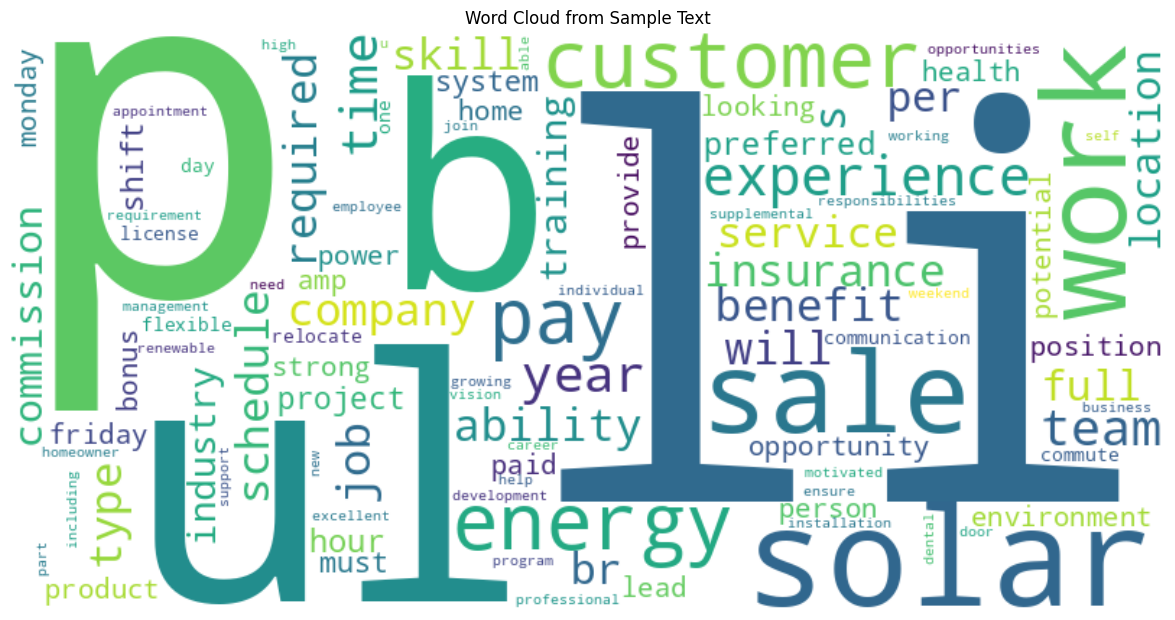

In [32]:
import re
from collections import Counter
from wordcloud import WordCloud # Import the WordCloud library
import matplotlib.pyplot as plt # Import matplotlib for displaying the image


word_soup_text = " ".join(descriptions[1])
text = word_soup_text.lower()

words = re.findall(r'\b[a-z]+\b', text)

processed_text = ' '.join(words)


wordcloud_generator = WordCloud(
    width=800,
    height=400,
    background_color='white',
    # stopwords=stop_words, # Uncomment this line if you defined a custom stop_words set above
    max_words=100,
    colormap='viridis',
    collocations=False, # Set to False to avoid grouping words like "word cloud"
    contour_width=1,
    contour_color='steelblue'
).generate(processed_text) # Generate the cloud from the processed text string

plt.figure(figsize=(12, 6)) # Set the figure size for display
plt.imshow(wordcloud_generator, interpolation='bilinear') # Display the image
plt.axis("off") # Hide the axes
plt.title("Word Cloud from Sample Text") # Add a title
plt.tight_layout(pad=0) # Adjust layout
plt.show() # Show the plot


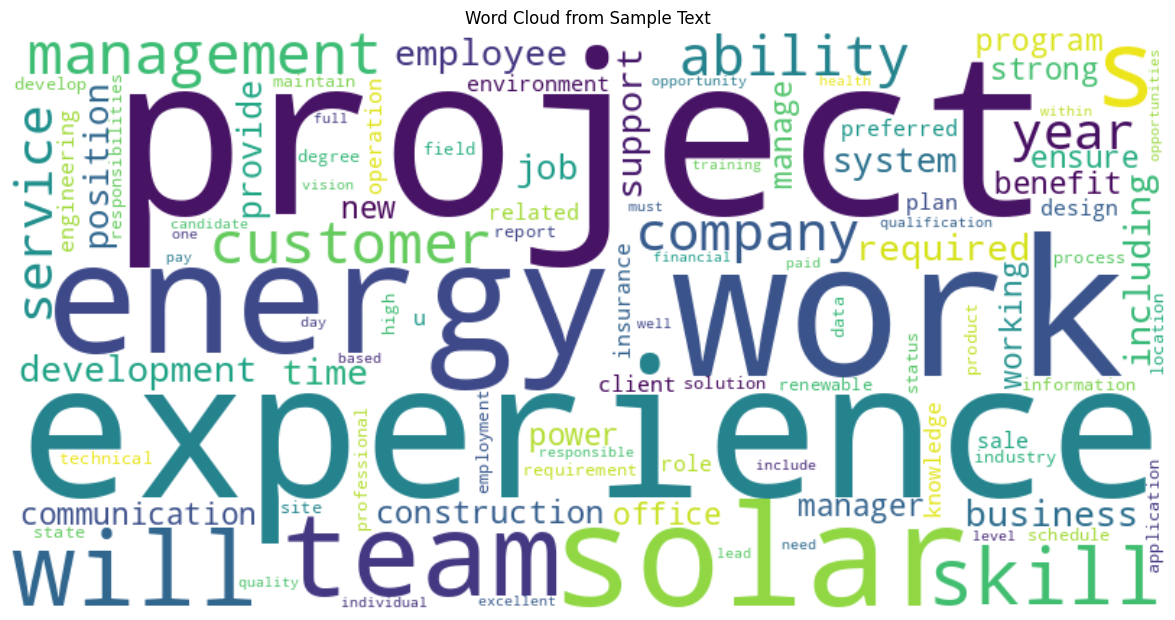

In [33]:
word_soup_text = " ".join(descriptions[2])
text = word_soup_text.lower()

words = re.findall(r'\b[a-z]+\b', text)

processed_text = ' '.join(words)


wordcloud_generator = WordCloud(
    width=800,
    height=400,
    background_color='white',
    # stopwords=stop_words, # Uncomment this line if you defined a custom stop_words set above
    max_words=100,
    colormap='viridis',
    collocations=False, # Set to False to avoid grouping words like "word cloud"
    contour_width=1,
    contour_color='steelblue'
).generate(processed_text) # Generate the cloud from the processed text string

plt.figure(figsize=(12, 6)) # Set the figure size for display
plt.imshow(wordcloud_generator, interpolation='bilinear') # Display the image
plt.axis("off") # Hide the axes
plt.title("Word Cloud from Sample Text") # Add a title
plt.tight_layout(pad=0) # Adjust layout
plt.show() # Show the plot

# Conclusion

In conclusion, both techniques—applying NMF after TF-IDF vectorization to identify topics via characteristic keywords, and using Sentence Transformers with K-Means clustering to group semantically similar documents—are valuable unsupervised approaches for revealing latent structures within a text dataset like job descriptions. They successfully surface potential themes and groupings that might otherwise be missed. However, a significant bottleneck remains: the considerable manual effort and subjective interpretation required to translate the outputs (lists of top words for NMF, or representative documents from K-Means clusters) into meaningful, concise topic labels. This is where Large Language Models (LLMs) present a compelling opportunity; they could potentially automate this laborious labeling process by analyzing the keywords or document examples and generating human-understandable topic names, thus bridging the gap between raw algorithmic output and actionable insights with much less manual intervention.